### Importing the required libraries

In [ ]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import re
from termcolor import colored
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

Getting the csv file from Drive

In [ ]:
downloaded = drive.CreateFile({'id':"1Z4ZHBCiqpVIwKGBHae0qBr45c46x5K4E"})   # replace the id with id of file you want to access
downloaded.GetContentFile('sentiment_final.csv') 

In [ ]:
df = pd.read_csv('sentiment_final.csv')
df.head(3)

,text,sentiment
0,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
1,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
2,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [ ]:
df.shape

(10729, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10729 entries, 0 to 10728
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       10729 non-null  object
 1   sentiment  10729 non-null  object
dtypes: object(2)
memory usage: 167.8+ KB


In [ ]:
sample_text = df['text'][0]

Simple Data Cleaning 

In [ ]:
def data_cleansing(text):
    text = re.sub(r'@[A-Z0-9a-z_:]+', '', text) #replace username-tags
    text = re.sub(r'^[RT]+', '', text) #replace RT-tags
    text = re.sub('https?://[A-Za-z0-9./]+', '', text) #replace URLs
    text = re.sub('n\'t', ' not', text) # replacing the don't and didn't with not
    text = re.sub('[^a-zA-Z]', ' ', text) #replace hashtags
    text_words = text.split()
    text_words = [word.lower() for word in text_words if len(word) >= 2]
    text = ' '.join(text_words)
    return text

In [ ]:
sample_text = data_cleansing(sample_text)

Removing the stopwords

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    pstem = PorterStemmer()
    lem = WordNetLemmatizer()
    text_words = [ word for word in text.split() if (word not in stop_words or word in ['not', 'can'])]
    # text_words = [ pstem.stem(lem.lemmatize(word)) for word in text_words ]
    text = ' '.join(text_words)
    return text

In [ ]:
print(colored('before removing the stopwords \n', 'red'), sample_text)
sample_text = remove_stop_words(sample_text)
print(colored('after removing the stopwords \n', 'red'), sample_text)

before removing the stopwords 
 did not catch the full gopdebate last night here are some of scott best lines in seconds walker
after removing the stopwords 
 not catch full gopdebate last night scott best lines seconds walker


In [ ]:
df['sentiment'].replace({'Positive': 1, 'Negative': 0}, inplace=True)

In [ ]:
all_texts = df['text'].values
all_labels = df['sentiment'].values

In [ ]:
all_texts = [
             remove_stop_words(data_cleansing(text))
             for text in tqdm(all_texts)
]

In [ ]:
all_texts[:10]

['not catch full gopdebate last night scott best lines seconds walker',
 'carly fiorina trending hours debate men completed gopdebate says',
 'gopdebate delivered highest ratings history presidential debates trump',
 'first day rescind every illegal executive action taken barack obama gopdebate',
 'liked happy heard going moderator not anymore gopdebate https',
 'deer headlights rt ben carson may brain surgeon performed lobotomy gopdebate',
 'last night debate proved gopdebate batsask tbats',
 'fairness billclinton owns phrase gopdebate',
 'woke tweet gopdebate best line night via',
 'reading family comments great gopdebate']

### Spelling Corrections

In [ ]:
# from textblob import TextBlob

In [ ]:
# for i in tqdm(range(len(all_texts))):
#     textBlb = TextBlob(all_texts[i])            # Making our first textblob
#     all_texts[i] = textBlb.correct()   # Correcting the text

### Word Clouds

In [ ]:
pos_text = ''
neg_text = ''
for i in range(len(all_labels)):
    if all_labels[i] == 1:
        pos_text += all_texts[i]
    elif all_labels[i] == 0:
        neg_text += all_texts[i]

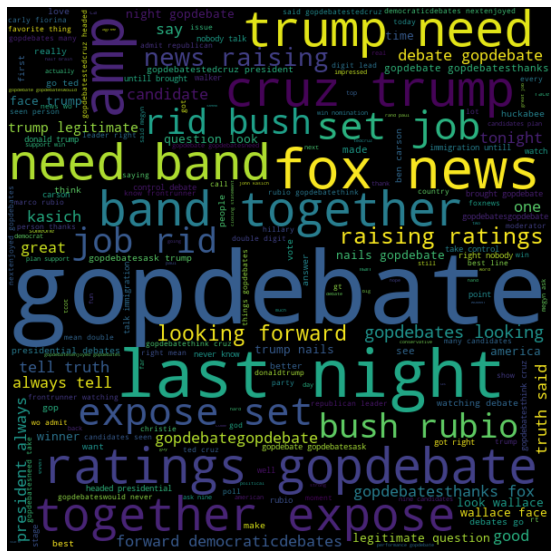

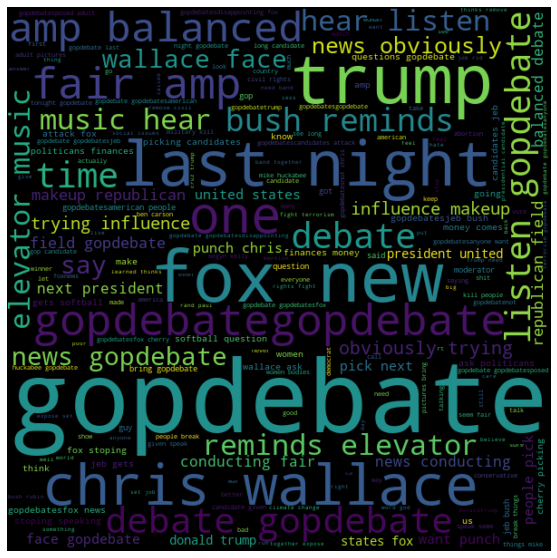

In [ ]:
from wordcloud import WordCloud
list_text = [pos_text, neg_text]
for txt in list_text:
    word_cloud = WordCloud(width = 600,height = 600,max_font_size = 200).generate(txt)
    plt.figure(figsize=(12,10))# create a new figure
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Word Embeddings

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',
            truncation=True,
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Encode our concatenated data
encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len)

Max length:  38


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([all_texts[0]])[0].squeeze().numpy())
print('Original: ', all_texts[0])
print('Token IDs: ', token_ids)

Original:  not catch full gopdebate last night scott best lines seconds walker
Token IDs:  [101, 2025, 4608, 2440, 2175, 17299, 15878, 3686, 2197, 2305, 3660, 2190, 3210, 3823, 5232, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


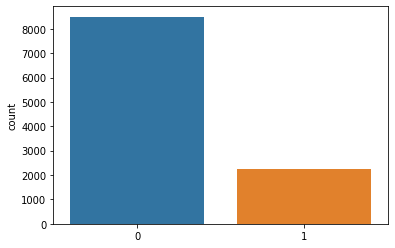

In [ ]:
sns.countplot(all_labels)

### Make train , validation, and test splits & Balancing the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_texts, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train = np.array(X_train).reshape(-1, 1)

X_train, y_train = ros.fit_resample(X_train, y_train)

X_train = X_train.squeeze(1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42, stratify=y_train)

In [ ]:
print('the shape of the train split: {}'.format(len(X_train)))
print('the shape of the validation split: {}'.format(len(X_val)))
print('the shape of the test split: {}'.format(len(X_test)))

the shape of the train split: 12093
the shape of the validation split: 1495
the shape of the test split: 2146


In [ ]:
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 38 µs, sys: 2 µs, total: 40 µs
Wall time: 44.6 µs


In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """

    val_accuracy_list = []
    train_accuracy_list = []
    val_loss_list = []
    train_loss_list = []

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

        train_epoch_accuracy_list = []
        train_epoch_loss_list = []
        
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()


            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()

            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_epoch_accuracy_list.append(accuracy)
            train_epoch_loss_list.append(loss.item())


            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy_list.append(np.mean(train_epoch_accuracy_list))
        train_loss_list.append(np.mean(train_epoch_loss_list))

        print("-"*70)

        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    return train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list = train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.677181   |     -      |     -     |   5.26   
   1    |   40    |   0.553095   |     -      |     -     |   5.01   
   1    |   60    |   0.514697   |     -      |     -     |   5.02   
   1    |   80    |   0.544629   |     -      |     -     |   5.02   
   1    |   100   |   0.439488   |     -      |     -     |   5.02   
   1    |   120   |   0.398948   |     -      |     -     |   5.03   
   1    |   140   |   0.438578   |     -      |     -     |   5.03   
   1    |   160   |   0.371563   |     -      |     -     |   5.02   
   1    |   180   |   0.366667   |     -      |     -     |   5.03   
   1    |   200   |   0.392315   |     -      |     -     |   5.02   
   1    |   220   |   0.362549   |     -      |     -     |   5.03   
   1    |   240   |   0.367116   |     -      |     -     |   5.02   


In [ ]:
def plot_train_test_metric(train_acc, val_acc, xlabel, ylabel, title, metric):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(train_acc, color='salmon', label='train {}'.format(metric), marker='o', linewidth=1)
    plt.annotate(str(np.round(train_acc[-1], 1)) + '%', (len(train_acc) - .8, train_acc[-1]), color='salmon')
    plt.plot(val_acc, color='skyblue', label='test {}'.format(metric), marker='o', linewidth=1)
    plt.annotate(str(np.round(val_acc[-1], 1)) + '%', (len(val_acc) - .8, val_acc[-1]), color='skyblue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y')

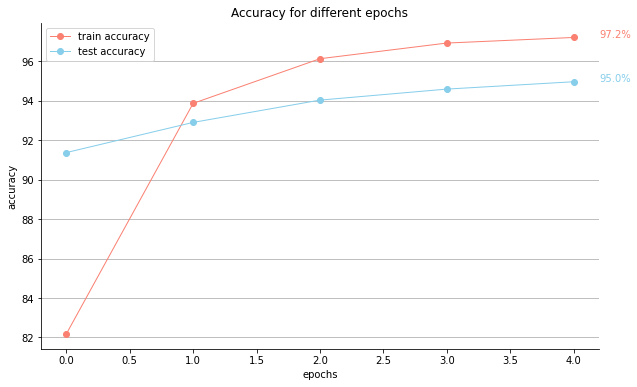

In [ ]:
plot_train_test_metric(train_accuracy_list, val_accuracy_list, "epochs", "accuracy", "Accuracy for different epochs", "accuracy")

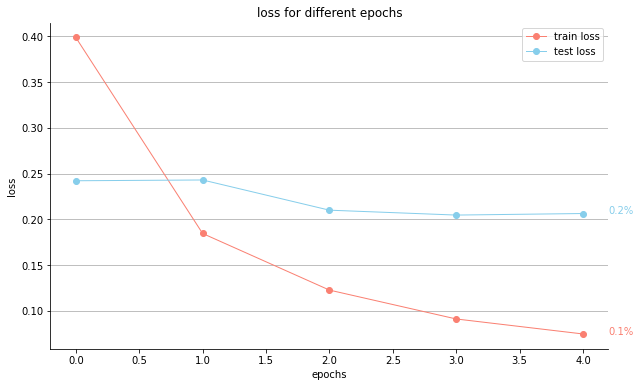

In [ ]:
plot_train_test_metric(train_loss_list, val_loss_list, "epochs", "loss", "loss for different epochs", "loss")

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9788
Accuracy: 94.98%


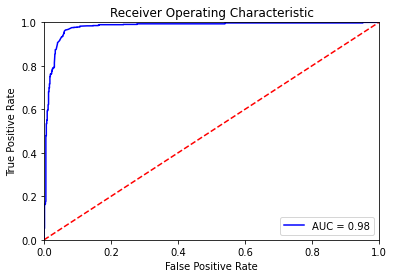

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())
print(classification_report(y_test, preds))

Number of tweets predicted non-negative:  396
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1699
           1       0.68      0.61      0.64       447

    accuracy                           0.86      2146
   macro avg       0.79      0.77      0.78      2146
weighted avg       0.85      0.86      0.86      2146



Text(0.5, 1.0, 'confusion matrix representing the performance of the model')

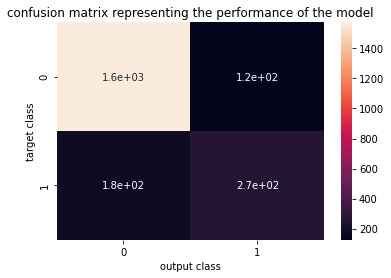

In [ ]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True)
plt.ylabel('target class')
plt.xlabel('output class')
plt.title('confusion matrix representing the performance of the model')